In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import statsmodels.formula.api as smf

## download the dataset from:
 https://github.com/picniclin/NYC_yl5240/blob/master/geolytics_NYC_census_1990-2010.csv

or

https://drive.google.com/a/nyu.edu/file/d/0B2HY61hRpF-jV21KSTVsbi1wS3M/view?usp=sharing

# To measure the relationship between the change of housing rent price and entropy index of income_level groups

# 1.Data acquisition and cleaning

In [2]:
df = pd.read_csv('/Users/apple/Downloads/geolytics_NYC_census_1990-2010.csv')

In [3]:
df.shape

(2168, 146)

In [4]:
df.columns

Index(['AREAKEY', 'STATE', 'STUSAB', 'INTPTLAT', 'INTPTLON', 'TCH_90_10',
       'TCH_00_10', 'ZCTA5', 'TRCTPOP9', 'POVRAT9N',
       ...
       'THY01001A', 'THY01251A', 'THY01501A', 'THY02001A', 'THY0M201A',
       'MDHHY1A', 'MDVALHS1A', 'MCSMORT1A', 'MCSNMOR1A', 'MDGRENT1A'],
      dtype='object', length=146)

In [5]:
df.head()

,AREAKEY,STATE,STUSAB,INTPTLAT,INTPTLON,TCH_90_10,TCH_00_10,ZCTA5,TRCTPOP9,POVRAT9N,...,THY01001A,THY01251A,THY01501A,THY02001A,THY0M201A,MDHHY1A,MDVALHS1A,MCSMORT1A,MCSNMOR1A,MDGRENT1A
0,36005000100,36,NY,40.793492,-73.883532,0,0,11370.0,14303,0,...,0,0,0,0,0,0,0,0,0,0
1,36005000200,36,NY,40.804573,-73.856859,3,3,10473.0,2907,411,...,152,203,48,68,11,59826,392500,2661,650,1273
2,36005000400,36,NY,40.808915,-73.850488,4,4,10473.0,2260,225,...,255,97,161,96,73,71968,393700,2206,679,1330
3,36005001600,36,NY,40.818848,-73.858076,0,0,10473.0,5254,893,...,171,20,38,20,0,30355,378100,2500,649,823
4,36005001900,36,NY,40.800999,-73.909373,4,4,10454.0,1575,797,...,14,19,21,0,0,25093,0,0,539,870


## make the column names readable

In [6]:
cols = df.columns.str.replace('TRCTPOP', 'pop')\
            .str.replace('MDFAMY','median_inc_fam_')\
            .str.replace('FAVINC', 'ave_inc_fam_')\
            .str.replace('MDHHY', 'median_inc_hh_')\
            .str.replace('AVHHIN', 'ave_inc_hh_')\
            .str.replace('FALTY', 'fam_inc_')\
            .str.replace('FALT', 'fam_inc_')\
            .str.replace('MXB', 'max_')\
            .str.replace('FAY0', 'fam_inc_')\
            .str.replace('fam_inc_M', 'fam_inc_max_')\
            .str.replace('THY0', 'hh_inc_' )\
            .str.replace('hh_inc_M', 'hh_inc_max_')\
            .str.replace('MDVALHS','median_house_value_')\
            .str.replace('MDGRENT', 'median_rent_' )\
            .str.replace('MCSMORT', 'owner_cost_mo_' )\
            .str.replace('MCSNMOR', 'owner_cost_no_mo_' )\
            .str.replace('OCCHU', 'occ_')\
            .str.replace('VACHU', 'vacant_')\
            .str.replace('RNTOCC','renter_occ_')\
            .str.replace('OWNOCC', 'owner_occ_')\
            .str.replace('SPRNTOC', 'spec_renter_occ_')\
            .str.replace('SPOWNOC', 'spec_owner_occ_')\
            .str.replace('PRSOCU', 'person_occ_')\
            .str.replace('PRSOWNU', 'person_owner_occ_')\
            .str.replace('PRSRNTU', 'person_renter_occ_')\
            .str.replace('POVRAT','poverty')\
            .str.replace('1A', '1')\
            .str.replace('9A', '9')
            
cols

Index(['AREAKEY', 'STATE', 'STUSAB', 'INTPTLAT', 'INTPTLON', 'TCH_90_10',
       'TCH_00_10', 'ZCTA5', 'pop9', 'poverty9N',
       ...
       'hh_inc_1001', 'hh_inc_1251', 'hh_inc_1501', 'hh_inc_2001',
       'hh_inc_max_201', 'median_inc_hh_1', 'median_house_value_1',
       'owner_cost_mo_1', 'owner_cost_no_mo_1', 'median_rent_1'],
      dtype='object', length=146)

In [7]:
df.columns = cols

df.rename(columns = {'AREAKEY' : 'census_tract_id',
                     'STATE':'state','STUSAB':'abb.',
                     'TCH_90_10':'tract_change_90', 'TCH_00_10':'tract_change_00',
                    'INTPTLAT':'lat', 'INTPTLON':'lon'}, inplace = True)
df.columns

Index(['census_tract_id', 'state', 'abb.', 'lat', 'lon', 'tract_change_90',
       'tract_change_00', 'ZCTA5', 'pop9', 'poverty9N',
       ...
       'hh_inc_1001', 'hh_inc_1251', 'hh_inc_1501', 'hh_inc_2001',
       'hh_inc_max_201', 'median_inc_hh_1', 'median_house_value_1',
       'owner_cost_mo_1', 'owner_cost_no_mo_1', 'median_rent_1'],
      dtype='object', length=146)

In [8]:
df = df.dropna()
df.ZCTA5 = df.ZCTA5.astype('int')
df.shape

(2157, 146)

In [9]:
## delete the observation, i.e. census tract, with 0 median rent or 0 median families income
df = df[~((df.median_rent_0 == 0)| (df.median_rent_9 == 0)|(df.median_rent_1 == 0)|\
         (df.median_inc_fam_9 == 0)| (df.median_inc_fam_9 == 0)|(df.median_inc_fam_1 == 0))]
df.shape

(2089, 146)

In [10]:
df.census_tract_id = df.census_tract_id.apply(lambda x : str(x)[-6:])

In [11]:
df.head()

,census_tract_id,state,abb.,lat,lon,tract_change_90,tract_change_00,ZCTA5,pop9,poverty9N,...,hh_inc_1001,hh_inc_1251,hh_inc_1501,hh_inc_2001,hh_inc_max_201,median_inc_hh_1,median_house_value_1,owner_cost_mo_1,owner_cost_no_mo_1,median_rent_1
1,000200,36,NY,40.804573,-73.856859,3,3,10473,2907,411,...,152,203,48,68,11,59826,392500,2661,650,1273
2,000400,36,NY,40.808915,-73.850488,4,4,10473,2260,225,...,255,97,161,96,73,71968,393700,2206,679,1330
3,001600,36,NY,40.818848,-73.858076,0,0,10473,5254,893,...,171,20,38,20,0,30355,378100,2500,649,823
4,001900,36,NY,40.800999,-73.909373,4,4,10454,1575,797,...,14,19,21,0,0,25093,0,0,539,870
5,002000,36,NY,40.817580,-73.866096,0,0,10473,9110,3423,...,180,161,0,45,12,24939,398100,2185,715,455


## Add the PUMA, NAT information for each census tract
#### the CensusTract/NTA/PUMA Equivalencies table could be found on this [link](https://www1.nyc.gov/site/planning/data-maps/nyc-population/geographic-reference.page)
 the downloaded linkage is https://www1.nyc.gov/assets/planning/download/office/data-maps/nyc-population/census2010/nyc2010census_tabulation_equiv.xlsx


In [12]:
df_census = pd.read_csv('/Users/apple/Desktop/CUSP/Civic/problem_set_2/data/2010CensusTract_PUMA_NTA.csv')

In [13]:
df_census.head()

,Borough,2010CensusTract,PUMA,NTA_Code,NTA_Name
0,Bronx,31000,3704,BX31,Allerton-Pelham Gardens
1,Bronx,31200,3704,BX31,Allerton-Pelham Gardens
2,Bronx,31400,3704,BX31,Allerton-Pelham Gardens
3,Bronx,31600,3704,BX31,Allerton-Pelham Gardens
4,Bronx,31800,3704,BX31,Allerton-Pelham Gardens


In [14]:
df_census.shape

(2168, 5)

In [15]:
df_census.rename(columns = { '2010CensusTract':'census_tract_id'}, inplace = True)
df_census.census_tract_id = df_census.census_tract_id.apply(lambda x : str(x).zfill(6))

In [16]:
len(set(df['census_tract_id']) - set(df_census['census_tract_id'])), \
len(set(df_census['census_tract_id']) - set(df['census_tract_id']) ), \
len(set(df['census_tract_id']))

(0, 32, 1303)

In [17]:
df_all = df.merge(df_census, on = 'census_tract_id')
df_all.head()

,census_tract_id,state,abb.,lat,lon,tract_change_90,tract_change_00,ZCTA5,pop9,poverty9N,...,hh_inc_max_201,median_inc_hh_1,median_house_value_1,owner_cost_mo_1,owner_cost_no_mo_1,median_rent_1,Borough,PUMA,NTA_Code,NTA_Name
0,000200,36,NY,40.804573,-73.856859,3,3,10473,2907,411,...,11,59826,392500,2661,650,1273,Bronx,3709,BX09,Soundview-Castle Hill-Clason Point-Harding Park
1,000200,36,NY,40.804573,-73.856859,3,3,10473,2907,411,...,11,59826,392500,2661,650,1273,Brooklyn,4012,BK32,Sunset Park West
2,000200,36,NY,40.804573,-73.856859,3,3,10473,2907,411,...,11,59826,392500,2661,650,1273,Queens,4111,QN53,Woodhaven
3,000200,36,NY,40.653213,-74.010971,0,0,11232,1019,531,...,0,54688,481500,3315,572,700,Bronx,3709,BX09,Soundview-Castle Hill-Clason Point-Harding Park
4,000200,36,NY,40.653213,-74.010971,0,0,11232,1019,531,...,0,54688,481500,3315,572,700,Brooklyn,4012,BK32,Sunset Park West


## 2. split the dataset into several sub-tables

## 2.1 Geographies data table
according to http://guides.newman.baruch.cuny.edu/nyc_data/nbhoods, New York City neighborhood census data could use Public Use Microdata Areas (PUMAs).


In [18]:
# the sub-table of census tract information, including census tract id, latitude, longitude, and ZCTA.
df_tract = df_all.iloc[:, [-4,0, -2,-1,-3,7,3,4]]
df_tract.head()

,Borough,census_tract_id,NTA_Code,NTA_Name,PUMA,ZCTA5,lat,lon
0,Bronx,000200,BX09,Soundview-Castle Hill-Clason Point-Harding Park,3709,10473,40.804573,-73.856859
1,Brooklyn,000200,BK32,Sunset Park West,4012,10473,40.804573,-73.856859
2,Queens,000200,QN53,Woodhaven,4111,10473,40.804573,-73.856859
3,Bronx,000200,BX09,Soundview-Castle Hill-Clason Point-Harding Park,3709,11232,40.653213,-74.010971
4,Brooklyn,000200,BK32,Sunset Park West,4012,11232,40.653213,-74.010971


## 2.2 Tables for different years

In [19]:
# the sub-table of different groups of families income level
df_family_income = df.loc[:,df.columns[df.columns.str.startswith('fam_inc_')]]
df_family_income_1990 = df_family_income.loc[:,
                                df_family_income.columns[df_family_income.columns.str.endswith('9')]]
df_family_income_2000 = df_family_income.loc[:,
                                df_family_income.columns[df_family_income.columns.str.endswith('0')]]
df_family_income_2010 = df_family_income.loc[:,
                                df_family_income.columns[df_family_income.columns.str.endswith('1')]]

 
df_family_income_1990.shape, df_family_income_2000.shape, df_family_income_2010.shape

((2089, 14), (2089, 16), (2089, 16))

In [20]:
df_1990 = df.iloc[:, 8:42]
df_2000 = df.iloc[:, 42:94]
df_2010 = df.iloc[:, 94:]
df_1990.shape, df_2000.shape, df_2010.shape

((2089, 34), (2089, 52), (2089, 52))

## 2.3 Housing tables, including data of house value and rent

In [21]:
# the sub-table of housing price and rent
df_house = df.loc[:,df.columns[(df.columns.str.startswith('median_rent_')) |\
                              (df.columns.str.startswith('median_house_'))]]
df_house.head()

,median_house_value_9,median_rent_9,median_house_value_0,median_rent_0,median_house_value_1,median_rent_1
1,136500,742,147500,730,392500,1273
2,163234,535,157610,643,393700,1330
3,156800,466,177000,558,378100,823
4,48868,422,145960,461,0,870
5,185400,298,177600,266,398100,455


In [22]:
df_house.describe()

,median_house_value_9,median_rent_9,median_house_value_0,median_rent_0,median_house_value_1,median_rent_1
count,2089.000000,2089.000000,2.089000e+03,2089.000000,2.089000e+03,2089.000000
mean,170909.090953,544.198181,2.233565e+05,753.071326,5.070657e+05,1151.020105
std,110359.984751,150.069074,1.826276e+05,231.835763,2.214706e+05,331.293631
min,0.000000,140.000000,0.000000e+00,175.000000,0.000000e+00,231.000000
25%,118204.000000,453.000000,1.604000e+05,644.000000,3.981000e+05,964.000000
50%,171500.000000,531.000000,1.964000e+05,740.000000,4.941000e+05,1120.000000
75%,218689.000000,629.000000,2.508000e+05,834.000000,6.275000e+05,1308.000000
max,500001.000000,1001.000000,1.000001e+06,2001.000000,1.000001e+06,2001.000000


## 2.4 Income tables

In [23]:
# the sub-table of median/average families/households income
df_income = df.loc[:,df.columns[(df.columns.str.startswith('median_inc_')) |\
                              (df.columns.str.startswith('ave_inc_'))]]
df_income.head()   

,ave_inc_fam_9,median_inc_fam_9,ave_inc_hh_9,median_inc_hh_9,ave_inc_fam_0,median_inc_fam_0,ave_inc_hh_0,median_inc_hh_0,ave_inc_fam_1,median_inc_fam_1,ave_inc_hh_1,median_inc_hh_1
1,45267.28710,38711,41034.78595,31632,50763.54348,50817,48547.32784,42539,67363.981,58368,66324.981,59826
2,43694.20068,40484,41850.02374,36506,48306.41829,41019,45697.79035,39111,86056.373,73148,82305.160,71968
3,30042.84776,24732,27803.12012,22739,36442.53563,30104,31610.56070,24552,43473.490,33555,38629.904,30355
4,23377.47813,24823,19303.58696,11215,31360.47431,23671,27995.65217,22772,35995.455,25489,33907.328,25093
5,25062.06250,18762,22262.06940,14765,26817.80645,19694,24885.52589,14691,41842.527,30817,35687.455,24939


In [24]:
df_income.describe()

,ave_inc_fam_9,median_inc_fam_9,ave_inc_hh_9,median_inc_hh_9,ave_inc_fam_0,median_inc_fam_0,ave_inc_hh_0,median_inc_hh_0,ave_inc_fam_1,median_inc_fam_1,ave_inc_hh_1,median_inc_hh_1
count,2089.000000,2089.000000,2089.000000,2089.000000,2089.000000,2089.000000,2089.000000,2089.000000,2089.00000,2089.000000,2089.000000,2089.000000
mean,46240.797301,37689.401628,39246.703235,31309.411202,63576.869583,48874.026807,54229.582025,40628.821446,85376.28443,66207.958353,72345.813173,54703.689325
std,28606.446820,18760.425689,19565.189172,13562.873547,45058.370638,28645.098401,29038.210224,18527.299709,62564.07724,39910.826453,40603.704702,25923.948148
min,0.000000,86.000000,0.000000,5360.000000,16376.090910,7354.000000,12747.077320,7863.000000,0.00000,8542.000000,0.000000,8694.000000
25%,30501.042240,24924.000000,27864.930300,21862.000000,40513.116200,30724.000000,37683.585970,27976.000000,52010.32700,40022.000000,48876.596000,36299.000000
50%,41866.927540,36218.000000,36208.754250,30417.000000,53041.525420,42590.000000,48376.129030,37936.000000,70564.74300,56726.000000,64120.604000,51127.000000
75%,53084.721130,46843.000000,46187.374640,39697.000000,69321.465430,58977.000000,62046.691640,50806.000000,93098.66200,80125.000000,82035.096000,68026.000000
max,327320.474100,150001.000000,248923.005700,147567.000000,450967.828700,200001.000000,337238.297900,174119.000000,636204.42600,250001.000000,464390.618000,232768.000000


# 3. Analysis based on census tract

## create the table for relationship analysis
To compare the 1990 data, we choose the family income, not household income.


The variables we need are median family income, median rent, families with different income level

In [25]:
df_1 = df.loc[:,df.columns[(df.columns.str.startswith('median_inc_fam'))|\
                                (df.columns.str.startswith('median_rent')) |\
                                (df.columns.str.startswith('fam_inc_'))]]

In [26]:
df_1.shape

(2089, 52)

In [27]:
df_1.columns

Index(['median_inc_fam_9', 'fam_inc_109', 'fam_inc_159', 'fam_inc_209',
       'fam_inc_259', 'fam_inc_309', 'fam_inc_359', 'fam_inc_409',
       'fam_inc_499', 'fam_inc_609', 'fam_inc_759', 'fam_inc_1009',
       'fam_inc_1259', 'fam_inc_1509', 'fam_inc_max_9', 'median_rent_9',
       'median_inc_fam_0', 'fam_inc_100', 'fam_inc_150', 'fam_inc_200',
       'fam_inc_250', 'fam_inc_300', 'fam_inc_350', 'fam_inc_400',
       'fam_inc_450', 'fam_inc_500', 'fam_inc_600', 'fam_inc_750',
       'fam_inc_1000', 'fam_inc_1250', 'fam_inc_1500', 'fam_inc_2000',
       'fam_inc_max_200', 'median_rent_0', 'median_inc_fam_1', 'fam_inc_101',
       'fam_inc_151', 'fam_inc_201', 'fam_inc_251', 'fam_inc_301',
       'fam_inc_351', 'fam_inc_401', 'fam_inc_451', 'fam_inc_501',
       'fam_inc_601', 'fam_inc_751', 'fam_inc_1001', 'fam_inc_1251',
       'fam_inc_1501', 'fam_inc_2001', 'fam_inc_max_201', 'median_rent_1'],
      dtype='object')

In [28]:
df2 = df.loc[:,df.columns[(df.columns.str.startswith('median_inc_fam'))|\
                                (df.columns.str.startswith('median_rent')) ]]

In [29]:
df2.head()

,median_inc_fam_9,median_rent_9,median_inc_fam_0,median_rent_0,median_inc_fam_1,median_rent_1
1,38711,742,50817,730,58368,1273
2,40484,535,41019,643,73148,1330
3,24732,466,30104,558,33555,823
4,24823,422,23671,461,25489,870
5,18762,298,19694,266,30817,455


In [30]:
df2['rent_income_ratio_9'] = df2['median_rent_9'] * 12/df2['median_inc_fam_9']
df2['rent_income_ratio_0'] = df2['median_rent_0'] * 12/df2['median_inc_fam_0']
df2['rent_income_ratio_1'] = df2['median_rent_1'] * 12/df2['median_inc_fam_1']

In [31]:
df2.describe()

,median_inc_fam_9,median_rent_9,median_inc_fam_0,median_rent_0,median_inc_fam_1,median_rent_1,rent_income_ratio_9,rent_income_ratio_0,rent_income_ratio_1
count,2089.000000,2089.000000,2089.000000,2089.000000,2089.000000,2089.000000,2089.000000,2089.000000,2089.000000
mean,37689.401628,544.198181,48874.026807,753.071326,66207.958353,1151.020105,0.259635,0.214373,0.248931
std,18760.425689,150.069074,28645.098401,231.835763,39910.826453,331.293631,2.738330,0.074864,0.100567
min,86.000000,140.000000,7354.000000,175.000000,8542.000000,231.000000,0.067760,0.010500,0.042308
25%,24924.000000,453.000000,30724.000000,644.000000,40022.000000,964.000000,0.151078,0.164954,0.181756
50%,36218.000000,531.000000,42590.000000,740.000000,56726.000000,1120.000000,0.183705,0.204193,0.235058
75%,46843.000000,629.000000,58977.000000,834.000000,80125.000000,1308.000000,0.227210,0.253730,0.300615
max,150001.000000,1001.000000,200001.000000,2001.000000,250001.000000,2001.000000,125.302326,1.194452,1.298057


In [32]:
df2.mean()

median_inc_fam_9       37689.401628
median_rent_9            544.198181
median_inc_fam_0       48874.026807
median_rent_0            753.071326
median_inc_fam_1       66207.958353
median_rent_1           1151.020105
rent_income_ratio_9        0.259635
rent_income_ratio_0        0.214373
rent_income_ratio_1        0.248931
dtype: float64

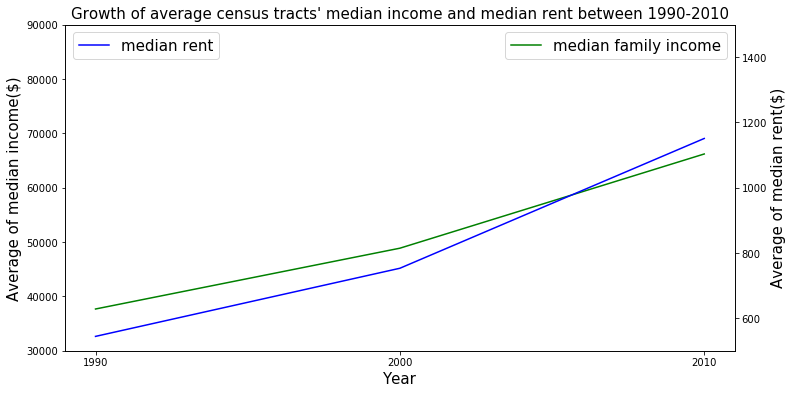

In [103]:

fig, ax1 = plt.subplots(figsize = (12, 6))
ax2 = ax1.twinx()
ax1.plot(np.arange(3), df2.mean().iloc[[0,2,4]], c = 'g', label = 'median family income')
ax2.plot(np.arange(3), df2.mean().iloc[[1,3,5]], c = 'b', label = 'median rent')
ax1.legend(loc = 'upper right', fontsize = 15)
ax2.legend(loc = 'upper left', fontsize = 15)

ax1.set_xlabel('Year', fontsize = 15)
ax1.set_ylabel('Average of median income($)', fontsize = 15)
ax1.set_ylim((30000,90000))

ax2.set_ylabel('Average of median rent($)', fontsize = 15)
ax2.set_ylim((500, 1500))

plt.xticks(np.arange(3), ('1990','2000','2010'))
plt.title("Growth of average census tracts' median income and median rent between 1990-2010", fontsize = 15)

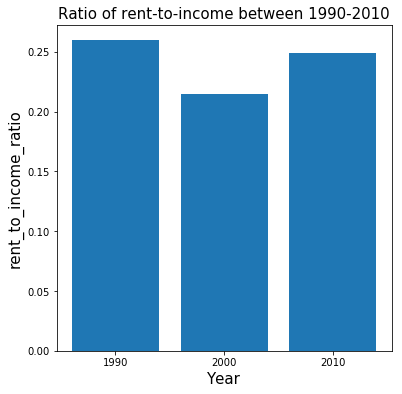

In [107]:
plt.figure(figsize = (6, 6))
plt.bar(np.arange(3), df2.mean()[6:9])

plt.xticks(np.arange(3), ('1990','2000','2010'))
plt.xlabel('Year', fontsize = 15)
plt.ylabel('rent_to_income_ratio', fontsize = 15)
plt.title('Ratio of rent-to-income between 1990-2010', fontsize = 15)

## Calculate the change of rent between 1990-2000 and 2000-2010

In [34]:
df2['rent_growth_90_00'] = df2.median_rent_0/df2.median_rent_9
df2['rent_growth_00_10'] = df2.median_rent_1/df2.median_rent_0

df2['inc_growth_90_00'] = df2.median_inc_fam_0/df2.median_inc_fam_9
df2['inc_growth_00_10'] = df2.median_inc_fam_1/df2.median_inc_fam_0
df2.head()

,median_inc_fam_9,median_rent_9,median_inc_fam_0,median_rent_0,median_inc_fam_1,median_rent_1,rent_income_ratio_9,rent_income_ratio_0,rent_income_ratio_1,rent_growth_90_00,rent_growth_00_10,inc_growth_90_00,inc_growth_00_10
1,38711,742,50817,730,58368,1273,0.230012,0.172383,0.261719,0.983827,1.743836,1.312728,1.148592
2,40484,535,41019,643,73148,1330,0.158581,0.188108,0.218188,1.201869,2.068429,1.013215,1.783271
3,24732,466,30104,558,33555,823,0.226104,0.222429,0.294323,1.197425,1.474910,1.217208,1.114636
4,24823,422,23671,461,25489,870,0.204004,0.233704,0.409588,1.092417,1.887202,0.953591,1.076803
5,18762,298,19694,266,30817,455,0.190598,0.162080,0.177175,0.892617,1.710526,1.049675,1.564791


In [35]:
df2.describe()

,median_inc_fam_9,median_rent_9,median_inc_fam_0,median_rent_0,median_inc_fam_1,median_rent_1,rent_income_ratio_9,rent_income_ratio_0,rent_income_ratio_1,rent_growth_90_00,rent_growth_00_10,inc_growth_90_00,inc_growth_00_10
count,2089.000000,2089.000000,2089.000000,2089.000000,2089.000000,2089.000000,2089.000000,2089.000000,2089.000000,2089.000000,2089.000000,2089.000000,2089.000000
mean,37689.401628,544.198181,48874.026807,753.071326,66207.958353,1151.020105,0.259635,0.214373,0.248931,1.394707,1.554580,2.017393,1.386582
std,18760.425689,150.069074,28645.098401,231.835763,39910.826453,331.293631,2.738330,0.074864,0.100567,0.243999,0.341645,32.109538,0.371344
min,86.000000,140.000000,7354.000000,175.000000,8542.000000,231.000000,0.067760,0.010500,0.042308,0.174825,0.326599,0.536671,0.210854
25%,24924.000000,453.000000,30724.000000,644.000000,40022.000000,964.000000,0.151078,0.164954,0.181756,1.272441,1.412500,1.100910,1.155940
50%,36218.000000,531.000000,42590.000000,740.000000,56726.000000,1120.000000,0.183705,0.204193,0.235058,1.378641,1.525917,1.250178,1.336591
75%,46843.000000,629.000000,58977.000000,834.000000,80125.000000,1308.000000,0.227210,0.253730,0.300615,1.486239,1.655766,1.426565,1.545935
max,150001.000000,1001.000000,200001.000000,2001.000000,250001.000000,2001.000000,125.302326,1.194452,1.298057,4.547727,11.434286,1468.779070,4.714033


## Calculate entropy index of different income-level groups for each census tract from 1990 to 2010

In [36]:
# define entropy index 
def entropy_index(x):
    Q_sum = 0
    for i in x:
        if i == 0:
            Q = 0
        else:
            Q = (-1) * (i/sum(x)) * np.log(i/sum(x))
        Q_sum += Q
    entropy_index = Q_sum/np.log(len(x))
    return entropy_index

In [37]:
# have a try
entropy_index(list(df_family_income_1990.iloc[0,:]))

0.92246865765414721

In [117]:
# calculate the entropy index of 1990
for i in df_family_income_1990.index:
    df_family_income_1990.loc[i,'entropy_index'] = \
                    entropy_index(list(df_family_income_1990.loc[i,'fam_inc_109':'fam_inc_max_9']))

In [118]:
df_family_income_1990.head()

,fam_inc_109,fam_inc_159,fam_inc_209,fam_inc_259,fam_inc_309,fam_inc_359,fam_inc_409,fam_inc_499,fam_inc_609,fam_inc_759,fam_inc_1009,fam_inc_1259,fam_inc_1509,fam_inc_max_9,entropy_index
1,29,29,12,31,20,32,31,84,75,59,68,35,18,2,0.922469
2,19,17,11,34,1,50,50,89,71,58,62,28,1,1,0.863543
3,142,28,124,84,41,165,39,161,69,70,45,11,0,0,0.863912
4,50,39,0,0,3,0,0,67,26,10,0,0,0,0,0.577145
5,284,201,107,60,74,131,95,203,158,40,84,8,0,13,0.875156


In [119]:
# calculate the entropy index of 2000 and 2010
for i in df_family_income_2000.index:
    df_family_income_2000.loc[i,'entropy_index'] = \
                    entropy_index(list(df_family_income_2000.loc[i,'fam_inc_100':'fam_inc_max_200']))

for i in df_family_income_2010.index:
    df_family_income_2010.loc[i,'entropy_index'] = \
                    entropy_index(list(df_family_income_2010.loc[i,'fam_inc_101':'fam_inc_max_201']))

In [42]:
# merge the entropy index data into df2
df2['entropy_index_9'] = df_family_income_1990.iloc[:,-1]
df2['entropy_index_0'] = df_family_income_2000.iloc[:,-1]
df2['entropy_index_1'] = df_family_income_2010.iloc[:,-1]
df2.head()

,median_inc_fam_9,median_rent_9,median_inc_fam_0,median_rent_0,median_inc_fam_1,median_rent_1,rent_income_ratio_9,rent_income_ratio_0,rent_income_ratio_1,rent_growth_90_00,rent_growth_00_10,inc_growth_90_00,inc_growth_00_10,entropy_index_9,entropy_index_0,entropy_index_1
1,38711,742,50817,730,58368,1273,0.230012,0.172383,0.261719,0.983827,1.743836,1.312728,1.148592,0.922469,0.871427,0.894048
2,40484,535,41019,643,73148,1330,0.158581,0.188108,0.218188,1.201869,2.068429,1.013215,1.783271,0.863543,0.914607,0.898725
3,24732,466,30104,558,33555,823,0.226104,0.222429,0.294323,1.197425,1.474910,1.217208,1.114636,0.863912,0.902281,0.894488
4,24823,422,23671,461,25489,870,0.204004,0.233704,0.409588,1.092417,1.887202,0.953591,1.076803,0.577145,0.825729,0.842364
5,18762,298,19694,266,30817,455,0.190598,0.162080,0.177175,0.892617,1.710526,1.049675,1.564791,0.875156,0.795292,0.918302


In [43]:
sum(np.array(df2 == 0))

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 2, 1])

In [44]:
## delete the observation with 0 entropy index
df_census_entropy = df2[~((df2.entropy_index_9 == 0)| (df2.entropy_index_0 == 0)|\
                          (df2.entropy_index_1 == 0))]

df_census_entropy.shape

(2080, 16)

In [45]:
sum(np.array(df_census_entropy == 0))

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [104]:
df_census_entropy.describe()

,median_inc_fam_9,median_rent_9,median_inc_fam_0,median_rent_0,median_inc_fam_1,median_rent_1,rent_income_ratio_9,rent_income_ratio_0,rent_income_ratio_1,rent_growth_90_00,rent_growth_00_10,inc_growth_90_00,inc_growth_00_10,entropy_index_9,entropy_index_0,entropy_index_1
count,2080.000000,2080.000000,2080.000000,2080.000000,2080.000000,2080.000000,2080.000000,2080.000000,2080.000000,2080.000000,2080.000000,2080.000000,2080.000000,2080.000000,2080.000000,2080.000000
mean,37747.926923,543.339423,48664.457212,751.245673,65960.824038,1148.772596,0.198773,0.214579,0.249093,1.393492,1.550774,1.304846,1.386766,0.837531,0.878937,0.837894
std,18752.333826,149.270985,28370.962672,227.074914,39541.366903,328.446693,0.075917,0.074811,0.100533,0.235155,0.264145,0.366783,0.367756,0.076998,0.066597,0.093337
min,4999.000000,140.000000,7354.000000,195.000000,8542.000000,231.000000,0.067760,0.047473,0.042308,0.624286,0.326599,0.536671,0.210854,0.172632,0.362708,0.199940
25%,25085.750000,453.000000,30718.000000,644.000000,40016.500000,964.000000,0.150911,0.164962,0.181956,1.272691,1.412871,1.100241,1.156685,0.811590,0.854212,0.804635
50%,36235.500000,531.000000,42470.000000,740.000000,56649.500000,1120.000000,0.183664,0.204214,0.235401,1.378611,1.526301,1.248453,1.336644,0.854884,0.896428,0.860526
75%,46918.500000,629.000000,58838.250000,833.000000,80021.000000,1305.250000,0.226743,0.253890,0.300631,1.485551,1.655776,1.421796,1.546234,0.885035,0.923663,0.899776
max,150001.000000,1001.000000,200001.000000,2001.000000,250001.000000,2001.000000,0.885777,1.194452,1.298057,4.547727,4.600000,8.984771,4.714033,0.962561,0.978050,0.979375


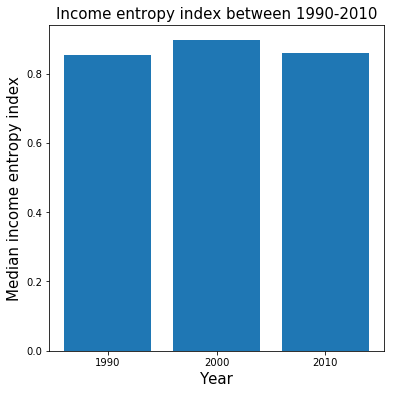

In [109]:
plt.figure(figsize = (6, 6))
plt.bar(np.arange(3), df_census_entropy.median()[-3:])

plt.xticks(np.arange(3), ('1990','2000','2010'))
plt.xlabel('Year', fontsize = 15)
plt.ylabel('Median income entropy index', fontsize = 15)
plt.title('Income entropy index between 1990-2010', fontsize = 15)

## OLS regression between rent growth and entropy index at the beginning point

In [46]:
lm1 = smf.ols('rent_growth_90_00 ~ entropy_index_9', df_census_entropy).fit()
lm2 = smf.ols('rent_growth_00_10 ~ entropy_index_0', df_census_entropy).fit()

In [47]:
lm1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      rent_growth_90_00   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     14.51
Date:                Tue, 14 Nov 2017   Prob (F-statistic):           0.000144
Time:                        15:56:31   Log-Likelihood:                 67.161
No. Observations:                2080   AIC:                            -130.3
Df Residuals:                    2078   BIC:                            -119.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercept           1.6065      0.056     28.609      0.000         1.496     1.717
entropy_index_9    -0.2543      0.067     -3.809      0.000        -0.385    -0.123
==============================================================================
Omnibus:                     1262.560   Durbin-Watson:                   1.604
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            39327.293
Skew:                           2.323   Prob(JB):                         0.00
Kurtosis:                      23.789   Cond. No.                         22.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [48]:
lm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      rent_growth_00_10   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     3.395
Date:                Tue, 14 Nov 2017   Prob (F-statistic):             0.0655
Time:                        15:56:31   Log-Likelihood:                -180.18
No. Observations:                2080   AIC:                             364.4
Df Residuals:                    2078   BIC:                             375.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercept           1.6916      0.077     22.074      0.000         1.541     1.842
entropy_index_0    -0.1602      0.087     -1.843      0.066        -0.331     0.010
==============================================================================
Omnibus:                      858.727   Durbin-Watson:                   1.976
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            13975.251
Skew:                           1.508   Prob(JB):                         0.00
Kurtosis:                      15.335   Cond. No.                         26.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Rent_growth = -0.254 * Tract_Entropy_Index + 1.606, R-squared = 0.007


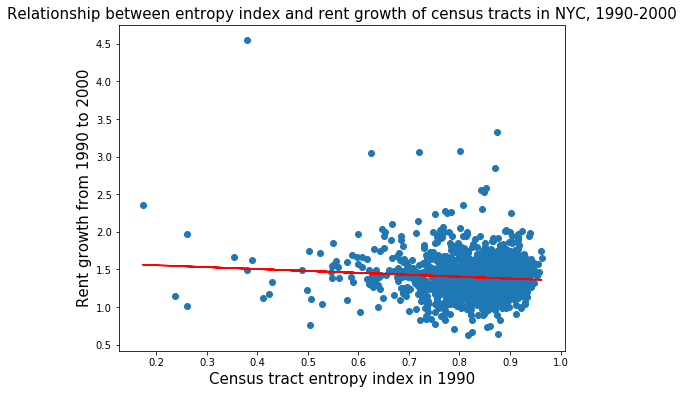

In [149]:
plt.figure(figsize = (8, 6))
plt.scatter(df_census_entropy.entropy_index_9, df_census_entropy.rent_growth_90_00)
plt.plot(df_census_entropy.entropy_index_9, lm1.predict(), c = 'r')
plt.xlabel('Census tract entropy index in 1990', fontsize = 15)
plt.ylabel('Rent growth from 1990 to 2000', fontsize = 15)
plt.title('Relationship between entropy index and rent growth of census tracts in NYC, 1990-2000',
         fontsize = 15)

print('Rent_growth_90to00 = {} * Tract_Entropy_Index_90 + {}, R-squared = {}'.format(round(lm1.params[1],3),
                                                            round(lm1.params[0],3),round(lm1.rsquared,3)))

Rent_growth_00to10 = -0.16 * Tract_Entropy_Index_00 + 1.692, R-squared = 0.002


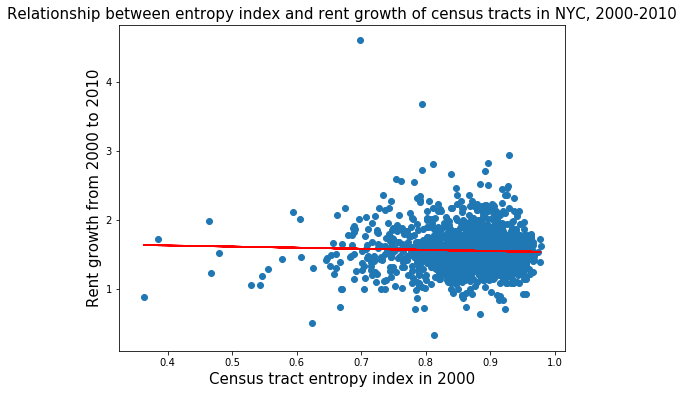

In [150]:
plt.figure(figsize = (8, 6))
plt.scatter(df_census_entropy.entropy_index_0, df_census_entropy.rent_growth_00_10)
plt.plot(df_census_entropy.entropy_index_0, lm2.predict(), c = 'r')
plt.xlabel('Census tract entropy index in 2000', fontsize = 15)
plt.ylabel('Rent growth from 2000 to 2010', fontsize = 15)
plt.title('Relationship between entropy index and rent growth of census tracts in NYC, 2000-2010',
         fontsize = 15)

print('Rent_growth_00to10 = {} * Tract_Entropy_Index_00 + {}, R-squared = {}'.format(round(lm2.params[1],3),
                                                            round(lm2.params[0],3),round(lm2.rsquared,3)))

# 4.Analysis based on PUMA neighborhoods

In [115]:
df_puma_median = df_tract[['PUMA']].merge(df_census_entropy, left_index = True, right_index = True).\
                    groupby(by = 'PUMA').median()
df_puma_median.head()

,median_inc_fam_9,median_rent_9,median_inc_fam_0,median_rent_0,median_inc_fam_1,median_rent_1,rent_income_ratio_9,rent_income_ratio_0,rent_income_ratio_1,rent_growth_90_00,rent_growth_00_10,inc_growth_90_00,inc_growth_00_10,entropy_index_9,entropy_index_0,entropy_index_1
PUMA,,,,,,,,,,,,,,,,
3701,43093.5,601.0,51299.5,792.0,69827.5,1185.5,0.173353,0.186543,0.221003,1.309663,1.519380,1.218818,1.335494,0.866469,0.906352,0.857246
3702,45789.0,616.0,59680.0,773.0,72583.0,1195.0,0.159000,0.155847,0.203589,1.290562,1.519841,1.222855,1.304801,0.858073,0.907500,0.862959
3703,35148.0,511.5,38471.5,708.0,53470.0,1048.0,0.181394,0.208824,0.219995,1.351332,1.497065,1.202688,1.397187,0.853181,0.899938,0.858110
3704,41902.0,590.0,52338.0,792.0,64000.0,1238.0,0.179329,0.188938,0.223488,1.364632,1.552913,1.226219,1.327971,0.861190,0.903512,0.867064
3705,42291.5,556.5,51623.0,752.0,64403.5,1120.5,0.170777,0.188410,0.219015,1.366631,1.485440,1.242204,1.321470,0.860499,0.902470,0.852672


In [114]:
df_puma_median.shape 

(46, 16)

In [116]:
df_puma_family_income = df_tract[['PUMA']].merge(df_family_income, left_index = True, right_index = True).\
                    groupby(by = 'PUMA').sum()
df_puma_family_income.head()

,fam_inc_109,fam_inc_159,fam_inc_209,fam_inc_259,fam_inc_309,fam_inc_359,fam_inc_409,fam_inc_499,fam_inc_609,fam_inc_759,...,fam_inc_401,fam_inc_451,fam_inc_501,fam_inc_601,fam_inc_751,fam_inc_1001,fam_inc_1251,fam_inc_1501,fam_inc_2001,fam_inc_max_201
PUMA,,,,,,,,,,,,,,,,,,,,,
3701,1956,1249,1535,1601,1373,3299,3627,5932,5237,5098,...,2014,2350,1829,4615,6377,7786,5733,3452,3492,2363
3702,903,531,700,648,822,1851,1815,4023,3387,3852,...,1389,1148,1018,2698,4077,6079,4222,2822,3099,2102
3703,4209,1408,1680,1872,1306,3292,3163,5687,4074,3510,...,1994,2509,2067,3832,4765,5632,3928,2115,1547,1382
3704,4781,2091,2384,2218,2365,5059,4431,8569,7015,7611,...,2896,3736,3171,5484,7208,9519,6970,4946,5480,6871
3705,4544,2082,2835,2321,2276,5325,4848,8875,7455,7974,...,3861,3396,2707,6332,7963,10145,7159,3877,5265,6351


## calculate the PUMA entropy index of 1990, 2000 and 2010

In [127]:

for i in df_puma_family_income.index:
    df_puma_family_income.loc[i,'entropy_index_9'] = \
                    entropy_index(list(df_puma_family_income.loc[i,'fam_inc_109':'fam_inc_max_9']))
    df_puma_family_income.loc[i,'entropy_index_0'] = \
                    entropy_index(list(df_puma_family_income.loc[i,'fam_inc_100':'fam_inc_max_200']))
    df_puma_family_income.loc[i,'entropy_index_1'] = \
                    entropy_index(list(df_puma_family_income.loc[i,'fam_inc_101':'fam_inc_max_201']))

In [128]:
df_puma_entropy = df_puma_family_income.loc[:,['entropy_index_9',
                                               'entropy_index_0','entropy_index_1']].\
                    merge(df_puma_median.loc[:, ['rent_growth_90_00', 'rent_growth_00_10']],
                         left_index = True, right_index = True)

In [129]:
df_puma_entropy

,entropy_index_9,entropy_index_0,entropy_index_1,rent_growth_90_00,rent_growth_00_10
PUMA,,,,,
3701,0.916918,0.959987,0.954573,1.309663,1.519380
3702,0.901506,0.952313,0.934941,1.290562,1.519841
3703,0.920183,0.952076,0.974322,1.351332,1.497065
3704,0.945310,0.974877,0.973698,1.364632,1.552913
3705,0.943918,0.972225,0.974122,1.366631,1.485440
3706,0.918853,0.958590,0.959438,1.245053,1.534262
3707,0.959451,0.980327,0.974650,1.412141,1.492487
3708,0.963710,0.978014,0.959880,1.417958,1.556557
3709,0.960644,0.966041,0.981687,1.429873,1.508294


In [130]:
lm1_puma = smf.ols('rent_growth_90_00 ~ entropy_index_9', df_puma_entropy).fit()
lm2_puma = smf.ols('rent_growth_00_10 ~ entropy_index_0', df_puma_entropy).fit()

In [131]:
lm1_puma.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      rent_growth_90_00   R-squared:                       0.357
Model:                            OLS   Adj. R-squared:                  0.342
Method:                 Least Squares   F-statistic:                     24.39
Date:                Tue, 14 Nov 2017   Prob (F-statistic):           1.18e-05
Time:                        17:08:16   Log-Likelihood:                 71.711
No. Observations:                  46   AIC:                            -139.4
Df Residuals:                      44   BIC:                            -135.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercept          -0.0023      0.279     -0.008      0.993        -0.564     0.560
entropy_index_9     1.4836      0.300      4.938      0.000         0.878     2.089
==============================================================================
Omnibus:                        5.481   Durbin-Watson:                   1.881
Prob(Omnibus):                  0.065   Jarque-Bera (JB):                5.460
Skew:                           0.379   Prob(JB):                       0.0652
Kurtosis:                       4.508   Cond. No.                         72.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [132]:
lm2_puma.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      rent_growth_00_10   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                 -0.015
Method:                 Least Squares   F-statistic:                    0.3491
Date:                Tue, 14 Nov 2017   Prob (F-statistic):              0.558
Time:                        17:08:31   Log-Likelihood:                 73.865
No. Observations:                  46   AIC:                            -143.7
Df Residuals:                      44   BIC:                            -140.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercept           1.3379      0.321      4.164      0.000         0.690     1.985
entropy_index_0     0.1994      0.337      0.591      0.558        -0.481     0.879
==============================================================================
Omnibus:                       17.774   Durbin-Watson:                   2.340
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               25.537
Skew:                           1.210   Prob(JB):                     2.85e-06
Kurtosis:                       5.732   Cond. No.                         87.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Rent_growth_90to00 = -0.002 + 1.484 * PUMA_Entropy_Index_90, R-squared = 0.357


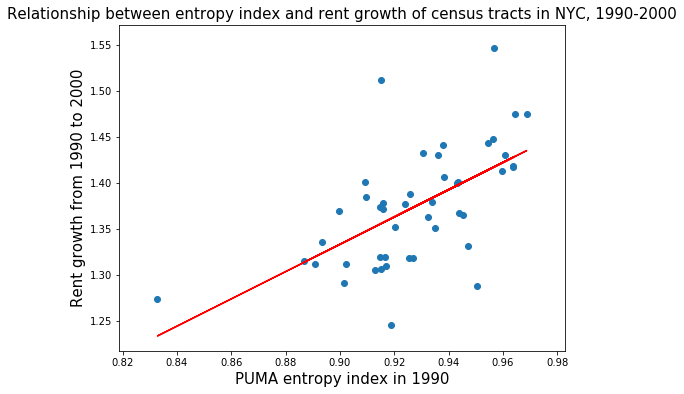

In [152]:
plt.figure(figsize = (8, 6))
plt.scatter(df_puma_entropy.entropy_index_9, df_puma_entropy.rent_growth_90_00)
plt.plot(df_puma_entropy.entropy_index_9, lm1_puma.predict(), c = 'r')
plt.xlabel('PUMA entropy index in 1990', fontsize = 15)
plt.ylabel('Rent growth from 1990 to 2000', fontsize = 15)
plt.title('Relationship between entropy index and rent growth of census tracts in NYC, 1990-2000',
         fontsize = 15)

print('Rent_growth_90to00 = {} + {} * PUMA_Entropy_Index_90, R-squared = {}'.format(\
                round(lm1_puma.params[0],3), round(lm1_puma.params[1],3),round(lm1_puma.rsquared,3)))

Rent_growth_00to10 = 1.338 + 0.199 * PUMA_Entropy_Index_00, R-squared = 0.008


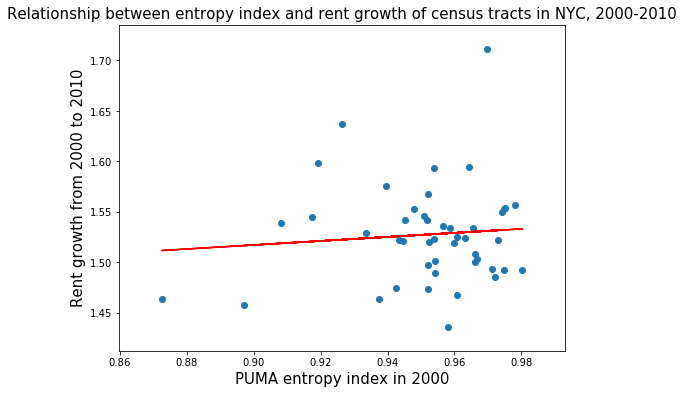

In [153]:
plt.figure(figsize = (8, 6))
plt.scatter(df_puma_entropy.entropy_index_0, df_puma_entropy.rent_growth_00_10)
plt.plot(df_puma_entropy.entropy_index_0, lm2_puma.predict(), c = 'r')
plt.xlabel('PUMA entropy index in 2000', fontsize = 15)
plt.ylabel('Rent growth from 2000 to 2010', fontsize = 15)
plt.title('Relationship between entropy index and rent growth of census tracts in NYC, 2000-2010',
         fontsize = 15)

print('Rent_growth_00to10 = {} + {} * PUMA_Entropy_Index_00, R-squared = {}'.format(\
                round(lm2_puma.params[0],3), round(lm2_puma.params[1],3),round(lm2_puma.rsquared,3)))